# Input Parameters

In [1]:
KNN_N = 4

# Import Package

In [2]:
SEED = 42

# 基本套件
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import os
from datetime import datetime

# Categorical Data Transforming
import category_encoders as ce
from sklearn.impute import KNNImputer

# Change Scaler
from sklearn.preprocessing import StandardScaler

# 資料集切割
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold

# 特徵篩選
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# 使用模型
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import catboost as cb
import lightgbm as lgbm
# import tensorflow as tf


# 資料視覺化
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


# 最佳化參數
import optuna
from optuna.integration import LightGBMPruningCallback

os.getcwd()

C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'C:\\Users\\USER\\Desktop\\Kev\\碩一\\人工智慧\\HW2'

# Read data

In [3]:
df = pd.read_csv(r'./train.csv')
print('view the data shape', df.shape)
df.head()

view the data shape (10108, 9)


,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,0,2008/9/30,Female,Service,No,2,3.0,3.8,0.16
1,1,2008/11/30,Male,Service,Yes,1,2.0,5.0,0.36
2,2,2008/3/10,Female,Product,Yes,2,NaN,5.8,0.49
3,3,2008/11/3,Male,Service,Yes,1,1.0,2.6,0.20
4,4,2008/7/24,Female,Service,No,3,7.0,6.9,0.52


In [4]:
# elliminate traget not na
df = df[df['Burn Rate'].notna()]

In [5]:
df = df[df.columns[1:]]
X = df[df.columns[:-1]]
y = df[df.columns[-1]]

C:\Users\USER\AppData\Local\Temp\ipykernel_9876\58359773.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


<AxesSubplot: >

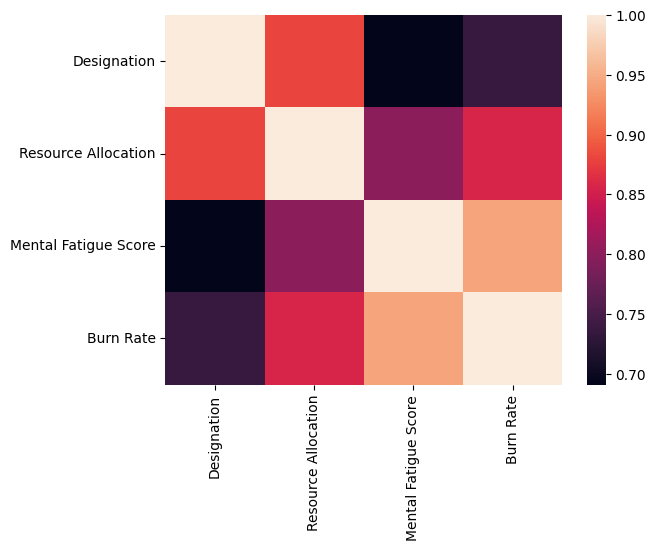

In [6]:
sns.heatmap(df.corr())

In [7]:
df.describe()

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
count,9624.000000,9041.000000,8738.000000,9624.000000
mean,2.183292,4.500055,5.731231,0.452351
std,1.141031,2.051501,1.921508,0.198787
min,0.000000,1.000000,0.000000,0.000000
25%,1.000000,3.000000,4.600000,0.320000
50%,2.000000,4.000000,5.900000,0.450000
75%,3.000000,6.000000,7.100000,0.590000
max,5.000000,10.000000,10.000000,1.000000


# Data Preprocessing

## Transfer Time related Data

In [8]:
def transfer_date(date):
    date_format = "%Y/%m/%d"
    a = datetime.strptime('2022/10/10', date_format)
    b = datetime.strptime(date, date_format)
    delta = a - b
    return delta.days

In [9]:
X['Date of Joining'] = X['Date of Joining'].apply(lambda x : transfer_date(x))

C:\Users\USER\AppData\Local\Temp\ipykernel_9876\1446608504.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Date of Joining'] = X['Date of Joining'].apply(lambda x : transfer_date(x))


## Categorical Data Transforming -  Target Encoder

In [10]:
## 原類別型
ce_leave = ce.GLMMEncoder(cols = ['Gender','Company Type','WFH Setup Available'],binomial_target = False,handle_unknown='value')
ce_leave.fit(X, y)     
X = ce_leave.transform(X)


## Normalize Data

In [11]:
# Normalization
Normalize_scaler = StandardScaler()
X = pd.DataFrame(Normalize_scaler.fit_transform(X), columns=X.columns, index=X.index)

## Fill Missing Value - KNN Imputer

<AxesSubplot: >

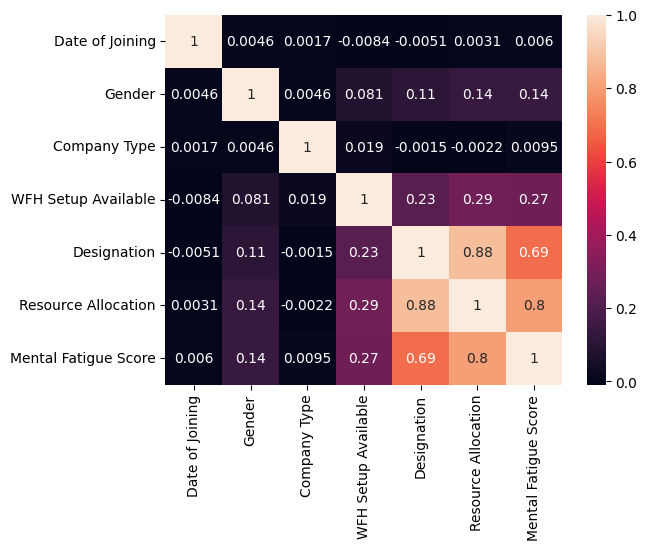

In [12]:
sns.heatmap(X.corr(),annot=True)

In [13]:
X.isna().sum()

Date of Joining           0
Gender                    0
Company Type              0
WFH Setup Available       0
Designation               0
Resource Allocation     583
Mental Fatigue Score    886
dtype: int64

In [14]:
# TODO
feature_list_xgb = ['WFH Setup Available','Gender',
       'Designation', 'Resource Allocation', 'Mental Fatigue Score','Burn Rate']

feature_list_cat = feature_list_xgb
feature_list_lgbm = feature_list_xgb

In [15]:
# TODO
X = X.loc[:,X.columns.isin(['WFH Setup Available','Gender',
       'Designation', 'Resource Allocation', 'Mental Fatigue Score'])]

In [16]:
# TODO

imputer = KNNImputer(n_neighbors= KNN_N)
X = pd.DataFrame(imputer.fit_transform(X),columns = X.columns)

In [17]:
X.isna().sum()

Gender                  0
WFH Setup Available     0
Designation             0
Resource Allocation     0
Mental Fatigue Score    0
dtype: int64

In [20]:
X.reset_index(drop=True,inplace=True)
y.reset_index(drop=True,inplace=True)
df= pd.concat([X,y],axis=1)

# Feature Selection

In [22]:
# def get_best_features(df):
#     score = df.loc['avg_score',:]
#     min_index = 1
#     for i in range(2,8):
#         if df.loc['avg_score',i]> df.loc['avg_score',min_index]:
#             min_index = i
#     return list(df.loc['feature_names',min_index])

## XGBoost

In [23]:
# # begin SFS
# model_xgb = xgb.XGBRegressor(random_state=SEED)

# sfs_XGB = SFS(model_xgb, 
#            k_features= int(round(X.shape[1],0)), 
#            floating=True,# 可以改false，如果跑太久
#            forward=True,  
#            verbose=2,
#            cv=5,
#            n_jobs=4)
# sfs_XGB = sfs_XGB.fit(X, y)

In [24]:
# feature_list_xgb = ['WFH Setup Available',
#  'Designation',
#  'Resource Allocation',
#  'Mental Fatigue Score']

## CatBoost

In [25]:
# # begin SFS
# model_cat = cb.CatBoostRegressor(random_state=SEED)

# sfs_CAT = SFS(model_cat, 
#            k_features= int(round(X.shape[1],0)), 
#            floating=True,# 可以改false，如果跑太久
#            forward=True,  
#            verbose=2,
#            cv=5,
#            n_jobs=4)
# sfs_CAT = sfs_CAT.fit(X, y)

In [26]:
# feature_list_cat = ['WFH Setup Available',
#  'Designation',
#  'Resource Allocation',
#  'Mental Fatigue Score']

## LightGBM

In [27]:
# # begin SFS
# model_lgbm = lgbm.LGBMRegressor(random_state=SEED)
# sfs_LGBM = SFS(model_lgbm, 
#            k_features= int(round(X.shape[1],0)), 
#            floating=True,# 可以改false，如果跑太久
#            forward=True,  
#            verbose=2,
#            cv=5,
#            n_jobs=4)
# sfs_LGBM = sfs_LGBM.fit(X, y)

In [28]:
# feature_list_lgbm = get_best_features(pd.DataFrame(sfs_LGBM.get_metric_dict()))

In [29]:
# feature_list_lgbm = ['WFH Setup Available',
#  'Designation',
#  'Resource Allocation',
#  'Mental Fatigue Score']

# Hypterparameter tuning - Optuna

## Objective Functions

In [30]:
# 分成不同盒子 - 分層抽樣用
def get_box(df):
    Y1_list = []
    for Y1 in df['Burn Rate']: 
        if (Y1 > np.percentile(df['Burn Rate'], 80)):
            Y1_list.append('3')
        elif (Y1 < np.percentile(df['Burn Rate'], 20)):
            Y1_list.append('2')
        else:
            Y1_list.append('1')
    df['box'] = Y1_list
    return df

In [31]:
def objective_lgbm(trial):
    param = {
        'metric': 'rmse',
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    
    model = lgbm.LGBMRegressor(**param,random_state=SEED)
    model.fit(X_train,y_train['Burn Rate'],eval_set=[(X_valid, y_valid['Burn Rate'])],early_stopping_rounds=100,verbose=False)
    y_pred = model.predict(X_valid)
    pred_list = y_pred.tolist()
    act_list = y_valid['Burn Rate'].tolist()

    error_list = []   
    for i in range(0, len(y_pred)):
        error_list.append(abs(round(act_list[i] - pred_list[i], 4)))
    abs_error_list_r4 =  [abs(ele) for ele in error_list]
    
    return sum(abs_error_list_r4)/len(abs_error_list_r4)

In [32]:
#optuna to set the hyperparameter of XGBoost
def objective_xgb(trial):
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 6, 15),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000, 100),
        'eta': trial.suggest_float("eta", 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'gamma': trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 10),
        'grow_policy': trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0)
    }
    model = xgb.XGBRegressor(**param,tree_method='gpu_hist',random_state=SEED).fit(X_train,y_train['Burn Rate'])
    y_pred = model.predict(X_valid)
    pred_list = y_pred.tolist()
    act_list = y_valid['Burn Rate'].tolist()

    error_list = []   
    for i in range(0, len(y_pred)):
        error_list.append(abs(round(act_list[i] - pred_list[i], 4)))
    abs_error_list_r4 =  [abs(ele) for ele in error_list]
    
    return sum(abs_error_list_r4)/len(abs_error_list_r4)

In [33]:
def objective_cat(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    param = {
        "loss_function": trial.suggest_categorical("loss_function", ["RMSE", "MAE"]),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e0),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 20),  
    }
    # Conditional Hyper-Parameters
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    reg = cb.CatBoostRegressor(**param)
    reg.fit(X_train, y_train['Burn Rate'], verbose=0, early_stopping_rounds=100)
    y_pred = reg.predict(X_valid)
    pred_list = y_pred.tolist()
    act_list = y_valid['Burn Rate'].tolist()

    error_list = []   
    for i in range(0, len(y_pred)):
        error_list.append(abs(round(act_list[i] - pred_list[i], 4)))
    abs_error_list_r4 =  [abs(ele) for ele in error_list]
    
    return sum(abs_error_list_r4)/len(abs_error_list_r4)

## XGBoost

In [34]:
# 分層抽樣因子
df = get_box(df)

X = df[df.columns[:-2]]
y = df[df.columns[-2:]]

# TODO
X = X.loc[:,X.columns.isin(feature_list_xgb)]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y['box'])

X_train.reset_index(drop=True,inplace=True)
X_valid.reset_index(drop=True,inplace=True) 
y_train.reset_index(drop=True,inplace=True) 
y_valid.reset_index(drop=True,inplace=True)


In [35]:
# optuna
study_xgb = optuna.create_study(direction="minimize")
study_xgb.optimize(objective_xgb, n_trials=100)

[I 2022-10-17 23:51:14,946] A new study created in memory with name: no-name-e2b6abb8-5141-4286-927b-2f49949a3372
[I 2022-10-17 23:51:49,682] Trial 0 finished with value: 0.166257038961039 and parameters: {'max_depth': 15, 'subsample': 0.8445081058187267, 'n_estimators': 1300, 'eta': 6.188209800423221e-07, 'alpha': 2.596296423849516e-06, 'lambda': 0.35249769098326245, 'gamma': 6.586146898233057e-08, 'min_child_weight': 2, 'grow_policy': 'lossguide', 'colsample_bytree': 0.9900782217302664}. Best is trial 0 with value: 0.166257038961039.
[I 2022-10-17 23:51:53,901] Trial 1 finished with value: 0.04998462337662344 and parameters: {'max_depth': 12, 'subsample': 0.33480757462396316, 'n_estimators': 1200, 'eta': 0.03511919468959644, 'alpha': 0.33462094313820845, 'lambda': 0.0004750183746678313, 'gamma': 1.0293307839327064e-05, 'min_child_weight': 10, 'grow_policy': 'depthwise', 'colsample_bytree': 0.6121472448860974}. Best is trial 1 with value: 0.04998462337662344.
[I 2022-10-17 23:51:56,26

[I 2022-10-17 23:53:39,733] Trial 19 finished with value: 0.05019246753246746 and parameters: {'max_depth': 11, 'subsample': 0.9002195691353855, 'n_estimators': 1600, 'eta': 0.0443853482593095, 'alpha': 0.0005894262314907349, 'lambda': 0.00018229316090552568, 'gamma': 0.00021813186069733796, 'min_child_weight': 7, 'grow_policy': 'depthwise', 'colsample_bytree': 0.5791900889803708}. Best is trial 1 with value: 0.04998462337662344.
[I 2022-10-17 23:53:45,464] Trial 20 finished with value: 0.05186150649350644 and parameters: {'max_depth': 8, 'subsample': 0.3061611273974477, 'n_estimators': 1600, 'eta': 0.11336961937141193, 'alpha': 0.06724765872694151, 'lambda': 0.0002562443690204312, 'gamma': 0.0004925540638595157, 'min_child_weight': 6, 'grow_policy': 'depthwise', 'colsample_bytree': 0.6318619978010678}. Best is trial 1 with value: 0.04998462337662344.
[I 2022-10-17 23:53:53,923] Trial 21 finished with value: 0.050238181818181814 and parameters: {'max_depth': 11, 'subsample': 0.90594411

[I 2022-10-17 23:55:25,556] Trial 38 finished with value: 0.054265454545454506 and parameters: {'max_depth': 8, 'subsample': 0.5311554004853446, 'n_estimators': 1200, 'eta': 0.001719454478307471, 'alpha': 0.00014057964188492027, 'lambda': 0.02620428405751605, 'gamma': 1.164882016843363e-06, 'min_child_weight': 3, 'grow_policy': 'lossguide', 'colsample_bytree': 0.9560263338729779}. Best is trial 25 with value: 0.049054025974026.
[I 2022-10-17 23:55:32,543] Trial 39 finished with value: 0.049741402597402645 and parameters: {'max_depth': 7, 'subsample': 0.6290135573941368, 'n_estimators': 1400, 'eta': 0.01173152172376219, 'alpha': 0.030252014310892465, 'lambda': 0.520330003655982, 'gamma': 7.555799752281012e-08, 'min_child_weight': 2, 'grow_policy': 'lossguide', 'colsample_bytree': 0.9100070519349114}. Best is trial 25 with value: 0.049054025974026.
[I 2022-10-17 23:55:36,185] Trial 40 finished with value: 0.05085080519480535 and parameters: {'max_depth': 6, 'subsample': 0.940769398484580

[I 2022-10-17 23:57:18,926] Trial 57 finished with value: 0.04965750649350656 and parameters: {'max_depth': 7, 'subsample': 0.579914731676129, 'n_estimators': 700, 'eta': 0.0302050298605326, 'alpha': 1.1122426694503602e-08, 'lambda': 0.4451193569211997, 'gamma': 1.7404117728116605e-08, 'min_child_weight': 2, 'grow_policy': 'lossguide', 'colsample_bytree': 0.787854530202604}. Best is trial 25 with value: 0.049054025974026.
[I 2022-10-17 23:57:22,205] Trial 58 finished with value: 0.1467920519480518 and parameters: {'max_depth': 6, 'subsample': 0.7611536762162338, 'n_estimators': 1000, 'eta': 0.00014449672238837455, 'alpha': 0.07601613397575344, 'lambda': 0.1036351627155921, 'gamma': 5.8305243193196394e-05, 'min_child_weight': 6, 'grow_policy': 'lossguide', 'colsample_bytree': 0.9748008602304225}. Best is trial 25 with value: 0.049054025974026.
[I 2022-10-17 23:57:26,495] Trial 59 finished with value: 0.0656993766233766 and parameters: {'max_depth': 6, 'subsample': 0.7186323050711926, 'n

[I 2022-10-17 23:58:01,719] Trial 76 finished with value: 0.04915309090909092 and parameters: {'max_depth': 8, 'subsample': 0.8175681088065728, 'n_estimators': 1000, 'eta': 0.10985950285431505, 'alpha': 0.0008331749421800454, 'lambda': 4.6980388356464343e-07, 'gamma': 0.005380251355779065, 'min_child_weight': 2, 'grow_policy': 'lossguide', 'colsample_bytree': 0.9433538415115791}. Best is trial 25 with value: 0.049054025974026.
[I 2022-10-17 23:58:02,285] Trial 77 finished with value: 0.04988259740259728 and parameters: {'max_depth': 7, 'subsample': 0.8003320506030853, 'n_estimators': 1000, 'eta': 0.12823789116571094, 'alpha': 0.0006582856874065592, 'lambda': 1.8537307276153617e-07, 'gamma': 0.03785151534291182, 'min_child_weight': 3, 'grow_policy': 'lossguide', 'colsample_bytree': 0.9506273488395374}. Best is trial 25 with value: 0.049054025974026.
[I 2022-10-17 23:58:03,938] Trial 78 finished with value: 0.051001090909090684 and parameters: {'max_depth': 8, 'subsample': 0.775902568209

[I 2022-10-17 23:58:53,897] Trial 95 finished with value: 0.04965833766233773 and parameters: {'max_depth': 8, 'subsample': 0.8361760750971771, 'n_estimators': 800, 'eta': 0.028333701230935145, 'alpha': 3.663939599828365e-07, 'lambda': 0.32635604185149686, 'gamma': 0.024642690418450477, 'min_child_weight': 2, 'grow_policy': 'lossguide', 'colsample_bytree': 0.9773555899312217}. Best is trial 25 with value: 0.049054025974026.
[I 2022-10-17 23:58:56,607] Trial 96 finished with value: 0.1663722077922078 and parameters: {'max_depth': 6, 'subsample': 0.6984688730105709, 'n_estimators': 1300, 'eta': 1.1619364340235726e-07, 'alpha': 1.1832297635365141e-08, 'lambda': 9.405028590829193e-08, 'gamma': 0.35676122771333874, 'min_child_weight': 2, 'grow_policy': 'lossguide', 'colsample_bytree': 0.9019855400237572}. Best is trial 25 with value: 0.049054025974026.
[I 2022-10-17 23:58:59,405] Trial 97 finished with value: 0.04932405194805189 and parameters: {'max_depth': 7, 'subsample': 0.56242430596845

## CatBoost

In [36]:
# 分層抽樣因子
df = get_box(df)

X = df[df.columns[:-2]]
y = df[df.columns[-2:]]

# TODO
X = X.loc[:,X.columns.isin(feature_list_cat)]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y['box'])

X_train.reset_index(drop=True,inplace=True)
X_valid.reset_index(drop=True,inplace=True) 
y_train.reset_index(drop=True,inplace=True) 
y_valid.reset_index(drop=True,inplace=True)


In [37]:
# optuna
study_cat = optuna.create_study(direction="minimize")
study_cat.optimize(objective_cat, n_trials=100)

[I 2022-10-17 23:59:06,865] A new study created in memory with name: no-name-9c3d8f7a-463b-4bb1-b961-121b6563982f
C:\Users\USER\AppData\Local\Temp\ipykernel_9876\150158002.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e0),
C:\Users\USER\AppData\Local\Temp\ipykernel_9876\150158002.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e0),
C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items inst

[I 2022-10-17 23:59:17,172] Trial 17 finished with value: 0.05094670129870123 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.25744270634117394, 'l2_leaf_reg': 0.010049341609654922, 'colsample_bylevel': 0.06970021654559298, 'depth': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 4, 'one_hot_max_size': 20}. Best is trial 7 with value: 0.04825537662337654.
[I 2022-10-17 23:59:18,217] Trial 18 finished with value: 0.05748955844155853 and parameters: {'loss_function': 'MAE', 'learning_rate': 0.029841002823311764, 'l2_leaf_reg': 0.1283462946365853, 'colsample_bylevel': 0.08901111442528861, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 17, 'one_hot_max_size': 15}. Best is trial 7 with value: 0.04825537662337654.
[I 2022-10-17 23:59:18,513] Trial 19 finished with value: 0.13357376623376632 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.0010707102306599285, 'l2_leaf_reg': 0.9189478110564485, 'colsamp

[I 2022-10-17 23:59:31,183] Trial 37 finished with value: 0.12304368831168803 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.002362717626964874, 'l2_leaf_reg': 0.0591822137636641, 'colsample_bylevel': 0.07049668016784294, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 14, 'one_hot_max_size': 15}. Best is trial 7 with value: 0.04825537662337654.
[I 2022-10-17 23:59:31,462] Trial 38 finished with value: 0.04968909090909086 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.5861407016494676, 'l2_leaf_reg': 0.09722560420993438, 'colsample_bylevel': 0.09396488441763107, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 8, 'subsample': 0.5108186935849158}. Best is trial 7 with value: 0.04825537662337654.
[I 2022-10-17 23:59:31,916] Trial 39 finished with value: 0.049921194805194816 and parameters: {'loss_function': 'MAE', 'learning_rate': 0.5210055264414858, 'l2_leaf_

[I 2022-10-17 23:59:39,468] Trial 56 finished with value: 0.049216935064935165 and parameters: {'loss_function': 'MAE', 'learning_rate': 0.988935721531147, 'l2_leaf_reg': 0.09988112580919818, 'colsample_bylevel': 0.09483783024779345, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 6, 'one_hot_max_size': 7, 'subsample': 0.4537623483953256}. Best is trial 7 with value: 0.04825537662337654.
[I 2022-10-17 23:59:39,930] Trial 57 finished with value: 0.0500025974025974 and parameters: {'loss_function': 'MAE', 'learning_rate': 0.42192002548297913, 'l2_leaf_reg': 0.10275874476477843, 'colsample_bylevel': 0.09696501742594085, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 6, 'one_hot_max_size': 7, 'subsample': 0.47121119851904414}. Best is trial 7 with value: 0.04825537662337654.
[I 2022-10-17 23:59:40,384] Trial 58 finished with value: 0.05010581818181806 and parameters: {'loss_function': 'MAE', 'learning_rate':

[I 2022-10-17 23:59:48,039] Trial 75 finished with value: 0.04881745454545464 and parameters: {'loss_function': 'MAE', 'learning_rate': 0.24000804317820862, 'l2_leaf_reg': 0.1828403637838915, 'colsample_bylevel': 0.0976768480868203, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 5, 'one_hot_max_size': 4, 'subsample': 0.8615783523661228}. Best is trial 7 with value: 0.04825537662337654.
[I 2022-10-17 23:59:48,305] Trial 76 finished with value: 0.051598649350649346 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.2530053975216068, 'l2_leaf_reg': 0.14677371233840134, 'colsample_bylevel': 0.09815566734213078, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 5, 'one_hot_max_size': 13, 'subsample': 0.8668709114050327}. Best is trial 7 with value: 0.04825537662337654.
[I 2022-10-17 23:59:48,785] Trial 77 finished with value: 0.050138025974026015 and parameters: {'loss_function': 'MAE', 'learning_rate

[I 2022-10-17 23:59:56,650] Trial 94 finished with value: 0.159290909090909 and parameters: {'loss_function': 'MAE', 'learning_rate': 0.00013243599410358623, 'l2_leaf_reg': 0.10727308793676849, 'colsample_bylevel': 0.09329599588776773, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 8, 'one_hot_max_size': 14, 'subsample': 0.9058280321550142}. Best is trial 7 with value: 0.04825537662337654.
[I 2022-10-17 23:59:57,141] Trial 95 finished with value: 0.04978550649350647 and parameters: {'loss_function': 'MAE', 'learning_rate': 0.21621107849565036, 'l2_leaf_reg': 0.18587648752682112, 'colsample_bylevel': 0.09603037189353916, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 8, 'one_hot_max_size': 11, 'subsample': 0.987160551890827}. Best is trial 7 with value: 0.04825537662337654.
[I 2022-10-17 23:59:57,645] Trial 96 finished with value: 0.05091724675324665 and parameters: {'loss_function': 'MAE', 'learning_rat

## LightGBM

In [38]:
# 分層抽樣因子
df = get_box(df)

X = df[df.columns[:-2]]
y = df[df.columns[-2:]]

# TODO
X = X.loc[:,X.columns.isin(feature_list_lgbm)]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y['box'])

X_train.reset_index(drop=True,inplace=True)
X_valid.reset_index(drop=True,inplace=True) 
y_train.reset_index(drop=True,inplace=True) 
y_valid.reset_index(drop=True,inplace=True)


In [39]:
# optuna
study_lgbm = optuna.create_study(direction="minimize")
study_lgbm.optimize(objective_lgbm, n_trials=100)

[I 2022-10-18 00:00:01,073] A new study created in memory with name: no-name-71e7417c-3a22-4a3d-a692-6d0fafc7e183
C:\Users\USER\AppData\Local\Temp\ipykernel_9876\3053857354.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\USER\AppData\Local\Temp\ipykernel_9876\3053857354.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release

[I 2022-10-18 00:00:38,173] Trial 18 finished with value: 0.051362441558441524 and parameters: {'reg_alpha': 0.39787734977296446, 'reg_lambda': 0.19668597098211132, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 834, 'min_child_samples': 262, 'min_data_per_groups': 47}. Best is trial 12 with value: 0.04981329870129875.
[I 2022-10-18 00:00:38,783] Trial 19 finished with value: 0.04979548051948054 and parameters: {'reg_alpha': 0.04325483550672334, 'reg_lambda': 0.006655672766945565, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 428, 'min_child_samples': 68, 'min_data_per_groups': 76}. Best is trial 19 with value: 0.04979548051948054.
[I 2022-10-18 00:00:39,321] Trial 20 finished with value: 0.04940597402597404 and parameters: {'reg_alpha': 0.07496940359048171, 'reg_lambda': 0.009268579770273094, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 10, 'num_le

[I 2022-10-18 00:01:07,810] Trial 40 finished with value: 0.050080831168831046 and parameters: {'reg_alpha': 1.9931644585541206, 'reg_lambda': 0.004513774056875045, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 20, 'num_leaves': 192, 'min_child_samples': 2, 'min_data_per_groups': 39}. Best is trial 23 with value: 0.04918088311688312.
[I 2022-10-18 00:01:08,337] Trial 41 finished with value: 0.04965345454545464 and parameters: {'reg_alpha': 0.08224354950087057, 'reg_lambda': 0.009013712769203921, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 437, 'min_child_samples': 18, 'min_data_per_groups': 80}. Best is trial 23 with value: 0.04918088311688312.
[I 2022-10-18 00:01:08,931] Trial 42 finished with value: 0.049300623376623366 and parameters: {'reg_alpha': 0.06771767212548589, 'reg_lambda': 0.004894861347953191, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 10, 'num_leave

[I 2022-10-18 00:01:33,920] Trial 62 finished with value: 0.0495959480519481 and parameters: {'reg_alpha': 0.0695193696004802, 'reg_lambda': 0.0022409856947881966, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 362, 'min_child_samples': 10, 'min_data_per_groups': 85}. Best is trial 23 with value: 0.04918088311688312.
[I 2022-10-18 00:01:34,740] Trial 63 finished with value: 0.04974405194805196 and parameters: {'reg_alpha': 0.029043594442446613, 'reg_lambda': 0.0013476373226912711, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 290, 'min_child_samples': 27, 'min_data_per_groups': 92}. Best is trial 23 with value: 0.04918088311688312.
[I 2022-10-18 00:01:36,137] Trial 64 finished with value: 0.05020898701298704 and parameters: {'reg_alpha': 0.0944089291174843, 'reg_lambda': 0.0035950598685784018, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 10, 'num_lea

[I 2022-10-18 00:01:54,347] Trial 84 finished with value: 0.04922857142857145 and parameters: {'reg_alpha': 0.42538773673892394, 'reg_lambda': 0.0017596091516768352, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 455, 'min_child_samples': 5, 'min_data_per_groups': 81}. Best is trial 23 with value: 0.04918088311688312.
[I 2022-10-18 00:01:56,390] Trial 85 finished with value: 0.049565142857142766 and parameters: {'reg_alpha': 0.4257234854442722, 'reg_lambda': 0.0018798846278604855, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 456, 'min_child_samples': 35, 'min_data_per_groups': 81}. Best is trial 23 with value: 0.04918088311688312.
[I 2022-10-18 00:01:57,660] Trial 86 finished with value: 0.049885142857142926 and parameters: {'reg_alpha': 0.3250341655044688, 'reg_lambda': 0.0012320718010573604, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 10, 'num_le

# Modeling

In [40]:
y = y[y.columns[0]]

## XGBoost

In [41]:
study_xgb.best_trial.params

{'max_depth': 9,
 'subsample': 0.6142740168938159,
 'n_estimators': 1100,
 'eta': 0.2936286723656779,
 'alpha': 0.017177120635059103,
 'lambda': 0.030778208818502698,
 'gamma': 0.008809498710661931,
 'min_child_weight': 5,
 'grow_policy': 'depthwise',
 'colsample_bytree': 0.8802123711903957}

In [42]:
# build model with best hyperparameter
model_xgb = xgb.XGBRegressor(**study_xgb.best_trial.params,random_state=SEED)

## CatBoost

In [43]:
study_cat.best_params

{'loss_function': 'RMSE',
 'learning_rate': 0.8351503275966912,
 'l2_leaf_reg': 0.042824448382658836,
 'colsample_bylevel': 0.09622398326865347,
 'depth': 10,
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS',
 'min_data_in_leaf': 4,
 'one_hot_max_size': 12}

In [44]:
# build model with best hyperparameter
model_cat = cb.CatBoostRegressor(**study_cat.best_params,random_state=SEED)

## LGBM

In [45]:
study_lgbm.best_trial.params

{'reg_alpha': 0.31427183224504357,
 'reg_lambda': 0.001203025205230218,
 'colsample_bytree': 0.8,
 'subsample': 0.5,
 'learning_rate': 0.014,
 'max_depth': 10,
 'num_leaves': 345,
 'min_child_samples': 4,
 'min_data_per_groups': 88}

In [46]:
# build model with best hyperparameter
model_lgbm = lgbm.LGBMRegressor(**study_lgbm.best_trial.params,random_state=SEED)

## Stacking

In [47]:
from sklearn.ensemble import StackingRegressor
from sklearn.neural_network import MLPRegressor


estimators = [
    ('xgb', model_xgb),
    ('cat', model_cat),
    ('lgbm', model_lgbm)
]
clf = StackingRegressor(
    estimators=estimators, final_estimator= MLPRegressor(activation = "relu", alpha = 0.1, hidden_layer_sizes = (8,8),
                            learning_rate = "constant", max_iter = 2000, random_state = 1000)
)

In [48]:
clf.fit(X_train, y_train['Burn Rate'])

print("訓練集 Score: ", clf.score(X_train,y_train['Burn Rate']))
print("測試集 Score: ", clf.score(X_valid,y_valid['Burn Rate']))

C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 0.1979721	total: 453us	remaining: 453ms
1:	learn: 0.1979721	total: 956us	remaining: 477ms
2:	learn: 0.1979721	total: 1.31ms	remaining: 435ms
3:	learn: 0.1979721	total: 1.64ms	remaining: 407ms
4:	learn: 0.1162819	total: 2.09ms	remaining: 416ms
5:	learn: 0.1162819	total: 2.41ms	remaining: 400ms
6:	learn: 0.1162819	total: 2.75ms	remaining: 391ms
7:	learn: 0.1034870	total: 3.24ms	remaining: 402ms
8:	learn: 0.1034870	total: 3.6ms	remaining: 396ms
9:	learn: 0.1034870	total: 3.95ms	remaining: 391ms
10:	learn: 0.1034870	total: 4.33ms	remaining: 389ms
11:	learn: 0.1034870	total: 4.69ms	remaining: 386ms
12:	learn: 0.0988006	total: 5.07ms	remaining: 385ms
13:	learn: 0.0988006	total: 5.39ms	remaining: 380ms
14:	learn: 0.0988006	total: 5.74ms	remaining: 377ms
15:	learn: 0.0987986	total: 6.17ms	remaining: 379ms
16:	learn: 0.0973356	total: 6.59ms	remaining: 381ms
17:	learn: 0.0905336	total: 7.15ms	remaining: 390ms
18:	learn: 0.0905336	total: 7.51ms	remaining: 388ms
19:	learn: 0.0900197	tota

487:	learn: 0.0602445	total: 181ms	remaining: 189ms
488:	learn: 0.0602445	total: 181ms	remaining: 189ms
489:	learn: 0.0602445	total: 181ms	remaining: 189ms
490:	learn: 0.0602445	total: 182ms	remaining: 188ms
491:	learn: 0.0602377	total: 182ms	remaining: 188ms
492:	learn: 0.0602355	total: 182ms	remaining: 188ms
493:	learn: 0.0602310	total: 183ms	remaining: 187ms
494:	learn: 0.0602310	total: 183ms	remaining: 187ms
495:	learn: 0.0602239	total: 184ms	remaining: 187ms
496:	learn: 0.0602181	total: 184ms	remaining: 186ms
497:	learn: 0.0602053	total: 184ms	remaining: 186ms
498:	learn: 0.0602053	total: 185ms	remaining: 186ms
499:	learn: 0.0601761	total: 185ms	remaining: 185ms
500:	learn: 0.0601751	total: 186ms	remaining: 185ms
501:	learn: 0.0601748	total: 186ms	remaining: 185ms
502:	learn: 0.0601748	total: 186ms	remaining: 184ms
503:	learn: 0.0601748	total: 187ms	remaining: 184ms
504:	learn: 0.0601312	total: 187ms	remaining: 184ms
505:	learn: 0.0601312	total: 188ms	remaining: 183ms
506:	learn: 

990:	learn: 0.0589724	total: 369ms	remaining: 3.35ms
991:	learn: 0.0589709	total: 369ms	remaining: 2.98ms
992:	learn: 0.0589709	total: 370ms	remaining: 2.6ms
993:	learn: 0.0589709	total: 370ms	remaining: 2.23ms
994:	learn: 0.0589709	total: 370ms	remaining: 1.86ms
995:	learn: 0.0589709	total: 371ms	remaining: 1.49ms
996:	learn: 0.0589709	total: 371ms	remaining: 1.12ms
997:	learn: 0.0589709	total: 371ms	remaining: 744us
998:	learn: 0.0589709	total: 372ms	remaining: 372us
999:	learn: 0.0589709	total: 372ms	remaining: 0us
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 0.1976866	total: 379us	remaining: 379ms
1:	learn: 0.1976866	total: 836us	remaining: 418ms
2:	learn: 0.1976866	total: 1.16ms	remaining: 385ms
3:	learn: 0.1976866	total: 1.46ms	remaining: 364ms
4:	learn: 0.1173309	total: 1.87ms	remaining: 373ms
5:	learn: 0.1173309	total: 2.17ms	remaining: 360ms
6:	learn: 0.1173309	total: 2.48ms	remaining: 352ms
7:	learn: 0.1043643	total: 2.91ms	remaining: 361ms
8:	learn: 0.1043643	total: 3.22ms	remaining: 354ms
9:	learn: 0.1043643	total: 3.52ms	remaining: 348ms
10:	learn: 0.1043643	total: 3.81ms	remaining: 343ms
11:	learn: 0.1043643	total: 4.11ms	remaining: 339ms
12:	learn: 0.0998062	total: 4.44ms	remaining: 337ms
13:	learn: 0.0998062	total: 4.76ms	remaining: 335ms
14:	learn: 0.0998062	total: 5.04ms	remaining: 331ms
15:	learn: 0.0998052	total: 5.37ms	remaining: 330ms
16:	learn: 0.0984696	total: 5.69ms	remaining: 329ms
17:	learn: 0.0912676	total: 6.21ms	remaining: 339ms
18:	learn: 0.0912676	total: 6.53ms	remaining: 337ms
19:	learn: 0.0907709	tot

557:	learn: 0.0602774	total: 182ms	remaining: 144ms
558:	learn: 0.0602774	total: 183ms	remaining: 144ms
559:	learn: 0.0602759	total: 183ms	remaining: 144ms
560:	learn: 0.0602759	total: 183ms	remaining: 144ms
561:	learn: 0.0602674	total: 184ms	remaining: 143ms
562:	learn: 0.0602671	total: 184ms	remaining: 143ms
563:	learn: 0.0602583	total: 184ms	remaining: 143ms
564:	learn: 0.0602496	total: 185ms	remaining: 142ms
565:	learn: 0.0602496	total: 185ms	remaining: 142ms
566:	learn: 0.0602496	total: 185ms	remaining: 142ms
567:	learn: 0.0602496	total: 186ms	remaining: 141ms
568:	learn: 0.0602496	total: 186ms	remaining: 141ms
569:	learn: 0.0602496	total: 186ms	remaining: 140ms
570:	learn: 0.0602496	total: 187ms	remaining: 140ms
571:	learn: 0.0602496	total: 187ms	remaining: 140ms
572:	learn: 0.0602496	total: 187ms	remaining: 140ms
573:	learn: 0.0602496	total: 188ms	remaining: 139ms
574:	learn: 0.0602496	total: 188ms	remaining: 139ms
575:	learn: 0.0602491	total: 189ms	remaining: 139ms
576:	learn: 

C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


88:	learn: 0.0666328	total: 29ms	remaining: 296ms
89:	learn: 0.0664241	total: 29.5ms	remaining: 298ms
90:	learn: 0.0662539	total: 29.8ms	remaining: 298ms
91:	learn: 0.0662539	total: 30.1ms	remaining: 297ms
92:	learn: 0.0660422	total: 30.4ms	remaining: 297ms
93:	learn: 0.0655976	total: 31ms	remaining: 299ms
94:	learn: 0.0655976	total: 31.3ms	remaining: 298ms
95:	learn: 0.0655976	total: 31.5ms	remaining: 297ms
96:	learn: 0.0655976	total: 31.8ms	remaining: 296ms
97:	learn: 0.0655976	total: 32.1ms	remaining: 295ms
98:	learn: 0.0655976	total: 32.3ms	remaining: 294ms
99:	learn: 0.0655443	total: 32.6ms	remaining: 294ms
100:	learn: 0.0655443	total: 32.9ms	remaining: 293ms
101:	learn: 0.0655443	total: 33.2ms	remaining: 292ms
102:	learn: 0.0655443	total: 33.5ms	remaining: 292ms
103:	learn: 0.0655443	total: 33.7ms	remaining: 291ms
104:	learn: 0.0655443	total: 34.1ms	remaining: 290ms
105:	learn: 0.0655443	total: 34.4ms	remaining: 290ms
106:	learn: 0.0655443	total: 34.6ms	remaining: 289ms
107:	lear

679:	learn: 0.0605072	total: 216ms	remaining: 102ms
680:	learn: 0.0605072	total: 216ms	remaining: 101ms
681:	learn: 0.0605072	total: 217ms	remaining: 101ms
682:	learn: 0.0605038	total: 217ms	remaining: 101ms
683:	learn: 0.0605038	total: 217ms	remaining: 100ms
684:	learn: 0.0605038	total: 218ms	remaining: 100ms
685:	learn: 0.0605038	total: 218ms	remaining: 99.8ms
686:	learn: 0.0605038	total: 218ms	remaining: 99.4ms
687:	learn: 0.0605038	total: 219ms	remaining: 99.1ms
688:	learn: 0.0605038	total: 219ms	remaining: 98.8ms
689:	learn: 0.0605038	total: 219ms	remaining: 98.4ms
690:	learn: 0.0604983	total: 219ms	remaining: 98.1ms
691:	learn: 0.0604983	total: 220ms	remaining: 97.8ms
692:	learn: 0.0604976	total: 220ms	remaining: 97.5ms
693:	learn: 0.0604976	total: 220ms	remaining: 97.1ms
694:	learn: 0.0604976	total: 221ms	remaining: 96.8ms
695:	learn: 0.0604740	total: 221ms	remaining: 96.6ms
696:	learn: 0.0604740	total: 221ms	remaining: 96.2ms
697:	learn: 0.0604740	total: 222ms	remaining: 95.9ms

C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


191:	learn: 0.0621411	total: 63.9ms	remaining: 269ms
192:	learn: 0.0621411	total: 64.3ms	remaining: 269ms
193:	learn: 0.0621411	total: 64.7ms	remaining: 269ms
194:	learn: 0.0620600	total: 65.2ms	remaining: 269ms
195:	learn: 0.0616433	total: 66ms	remaining: 271ms
196:	learn: 0.0616433	total: 66.3ms	remaining: 270ms
197:	learn: 0.0616433	total: 66.6ms	remaining: 270ms
198:	learn: 0.0616433	total: 66.9ms	remaining: 269ms
199:	learn: 0.0616140	total: 67.3ms	remaining: 269ms
200:	learn: 0.0616140	total: 67.5ms	remaining: 269ms
201:	learn: 0.0616093	total: 67.9ms	remaining: 268ms
202:	learn: 0.0616093	total: 68.1ms	remaining: 268ms
203:	learn: 0.0616093	total: 68.4ms	remaining: 267ms
204:	learn: 0.0616077	total: 68.8ms	remaining: 267ms
205:	learn: 0.0615857	total: 69.2ms	remaining: 267ms
206:	learn: 0.0615857	total: 69.4ms	remaining: 266ms
207:	learn: 0.0615857	total: 69.7ms	remaining: 265ms
208:	learn: 0.0615857	total: 70ms	remaining: 265ms
209:	learn: 0.0615857	total: 70.3ms	remaining: 264

738:	learn: 0.0590954	total: 251ms	remaining: 88.7ms
739:	learn: 0.0590954	total: 252ms	remaining: 88.4ms
740:	learn: 0.0590954	total: 252ms	remaining: 88.1ms
741:	learn: 0.0590863	total: 252ms	remaining: 87.8ms
742:	learn: 0.0590863	total: 253ms	remaining: 87.4ms
743:	learn: 0.0590835	total: 253ms	remaining: 87.1ms
744:	learn: 0.0590835	total: 253ms	remaining: 86.7ms
745:	learn: 0.0590835	total: 254ms	remaining: 86.4ms
746:	learn: 0.0590835	total: 254ms	remaining: 86ms
747:	learn: 0.0590835	total: 254ms	remaining: 85.7ms
748:	learn: 0.0590472	total: 255ms	remaining: 85.4ms
749:	learn: 0.0590472	total: 255ms	remaining: 85.1ms
750:	learn: 0.0590472	total: 256ms	remaining: 84.7ms
751:	learn: 0.0590472	total: 256ms	remaining: 84.4ms
752:	learn: 0.0590472	total: 256ms	remaining: 84.1ms
753:	learn: 0.0590472	total: 257ms	remaining: 83.7ms
754:	learn: 0.0590472	total: 257ms	remaining: 83.4ms
755:	learn: 0.0590472	total: 257ms	remaining: 83ms
756:	learn: 0.0590472	total: 258ms	remaining: 82.7

C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


214:	learn: 0.0617864	total: 68.6ms	remaining: 250ms
215:	learn: 0.0617864	total: 68.9ms	remaining: 250ms
216:	learn: 0.0617864	total: 69.2ms	remaining: 250ms
217:	learn: 0.0617667	total: 69.5ms	remaining: 249ms
218:	learn: 0.0617667	total: 69.8ms	remaining: 249ms
219:	learn: 0.0617667	total: 70.1ms	remaining: 249ms
220:	learn: 0.0617664	total: 70.4ms	remaining: 248ms
221:	learn: 0.0617664	total: 70.7ms	remaining: 248ms
222:	learn: 0.0617664	total: 71ms	remaining: 247ms
223:	learn: 0.0617617	total: 71.3ms	remaining: 247ms
224:	learn: 0.0617617	total: 71.6ms	remaining: 247ms
225:	learn: 0.0617617	total: 71.9ms	remaining: 246ms
226:	learn: 0.0617617	total: 72.2ms	remaining: 246ms
227:	learn: 0.0617617	total: 72.4ms	remaining: 245ms
228:	learn: 0.0617617	total: 72.7ms	remaining: 245ms
229:	learn: 0.0617613	total: 73ms	remaining: 244ms
230:	learn: 0.0617613	total: 73.3ms	remaining: 244ms
231:	learn: 0.0617613	total: 73.6ms	remaining: 244ms
232:	learn: 0.0617613	total: 73.9ms	remaining: 243

797:	learn: 0.0589929	total: 252ms	remaining: 63.9ms
798:	learn: 0.0589927	total: 253ms	remaining: 63.6ms
799:	learn: 0.0589927	total: 253ms	remaining: 63.3ms
800:	learn: 0.0589927	total: 253ms	remaining: 62.9ms
801:	learn: 0.0589927	total: 254ms	remaining: 62.6ms
802:	learn: 0.0589927	total: 254ms	remaining: 62.3ms
803:	learn: 0.0589927	total: 254ms	remaining: 62ms
804:	learn: 0.0589927	total: 255ms	remaining: 61.7ms
805:	learn: 0.0589925	total: 255ms	remaining: 61.4ms
806:	learn: 0.0589919	total: 256ms	remaining: 61.1ms
807:	learn: 0.0589919	total: 256ms	remaining: 60.8ms
808:	learn: 0.0589919	total: 256ms	remaining: 60.5ms
809:	learn: 0.0589919	total: 257ms	remaining: 60.2ms
810:	learn: 0.0589919	total: 257ms	remaining: 59.8ms
811:	learn: 0.0589919	total: 257ms	remaining: 59.5ms
812:	learn: 0.0589729	total: 258ms	remaining: 59.2ms
813:	learn: 0.0589729	total: 258ms	remaining: 58.9ms
814:	learn: 0.0589729	total: 258ms	remaining: 58.6ms
815:	learn: 0.0589697	total: 259ms	remaining: 58

C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


321:	learn: 0.0605214	total: 104ms	remaining: 218ms
322:	learn: 0.0605214	total: 104ms	remaining: 218ms
323:	learn: 0.0605214	total: 104ms	remaining: 218ms
324:	learn: 0.0605214	total: 105ms	remaining: 217ms
325:	learn: 0.0604419	total: 105ms	remaining: 218ms
326:	learn: 0.0604419	total: 106ms	remaining: 217ms
327:	learn: 0.0604418	total: 106ms	remaining: 217ms
328:	learn: 0.0604418	total: 106ms	remaining: 217ms
329:	learn: 0.0604418	total: 106ms	remaining: 216ms
330:	learn: 0.0604418	total: 107ms	remaining: 216ms
331:	learn: 0.0604418	total: 107ms	remaining: 215ms
332:	learn: 0.0604349	total: 107ms	remaining: 215ms
333:	learn: 0.0604286	total: 108ms	remaining: 215ms
334:	learn: 0.0604276	total: 108ms	remaining: 214ms
335:	learn: 0.0604276	total: 108ms	remaining: 214ms
336:	learn: 0.0604276	total: 109ms	remaining: 214ms
337:	learn: 0.0604276	total: 109ms	remaining: 213ms
338:	learn: 0.0604276	total: 109ms	remaining: 213ms
339:	learn: 0.0604276	total: 109ms	remaining: 213ms
340:	learn: 

903:	learn: 0.0589208	total: 289ms	remaining: 30.7ms
904:	learn: 0.0589208	total: 289ms	remaining: 30.4ms
905:	learn: 0.0589208	total: 290ms	remaining: 30.1ms
906:	learn: 0.0588913	total: 290ms	remaining: 29.8ms
907:	learn: 0.0588913	total: 290ms	remaining: 29.4ms
908:	learn: 0.0588907	total: 291ms	remaining: 29.1ms
909:	learn: 0.0588907	total: 291ms	remaining: 28.8ms
910:	learn: 0.0588907	total: 291ms	remaining: 28.5ms
911:	learn: 0.0588907	total: 292ms	remaining: 28.1ms
912:	learn: 0.0588907	total: 292ms	remaining: 27.8ms
913:	learn: 0.0588907	total: 292ms	remaining: 27.5ms
914:	learn: 0.0588906	total: 293ms	remaining: 27.2ms
915:	learn: 0.0588906	total: 293ms	remaining: 26.9ms
916:	learn: 0.0588906	total: 293ms	remaining: 26.5ms
917:	learn: 0.0588882	total: 294ms	remaining: 26.2ms
918:	learn: 0.0588881	total: 294ms	remaining: 25.9ms
919:	learn: 0.0588811	total: 294ms	remaining: 25.6ms
920:	learn: 0.0588811	total: 295ms	remaining: 25.3ms
921:	learn: 0.0588811	total: 295ms	remaining: 

C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


## Cross validation
- usually we will do cross validation to evaluate the generalization of model
- or you can just use ```sklearn.model_selection.train_test_split``` to evaluate your model

In [49]:
# # TODO
# # Using Stratified K fold to find result
# # skf = StratifiedKFold(n_splits=5,random_state=SEED)

# scores = cross_val_score(clf, X, y, cv=5)
# print("R2: %0.2f (std: %0.2f)" % (scores.mean(), scores.std()))
# print(scores)
# # need other scoring
# scores = cross_validate(clf, X, y, cv=5,
#                        scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error'))
# print("====================================")
# print("R2: {} (std: {})".format(scores['test_r2'].mean(), scores['test_r2'].std()))
# print("MSE: {} (std: {})".format(-scores['test_neg_mean_squared_error'].mean(), scores['test_neg_mean_squared_error'].std()))
# print("MAPE: {} (std: {})".format(-scores['test_neg_mean_absolute_percentage_error'].mean(), scores['test_neg_mean_absolute_percentage_error'].std()))

# Prediction
1. read data
2. model prediction
3. to_csv

In [50]:
df_test = pd.read_csv(r'./test.csv')
print(df_test.shape)
df_test.head()

(1980, 8)


,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score
0,0,2008/11/12,Male,Service,Yes,0,1.0,0.0
1,1,2008/3/11,Male,Product,No,3,8.0,7.9
2,2,2008/4/3,Male,Service,No,4,9.0,8.1
3,3,2008/10/1,Male,Product,No,1,3.0,5.7
4,4,2008/1/5,Female,Service,No,3,5.0,NaN


In [51]:
X_test = df_test[df_test.columns[1:]]

## Data Preprocessing for testing

## Transfer Time related Data

In [52]:
def transfer_date(date):
    date_format = "%Y/%m/%d"
    a = datetime.strptime('2022/10/10', date_format)
    b = datetime.strptime(date, date_format)
    delta = a - b
    return delta.days

In [53]:
X_test['Date of Joining'] = X_test['Date of Joining'].apply(lambda x : transfer_date(x))

C:\Users\USER\AppData\Local\Temp\ipykernel_9876\345012162.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Date of Joining'] = X_test['Date of Joining'].apply(lambda x : transfer_date(x))


## Categorical Data Transforming -  Target Encoder

In [54]:
## 原類別型
X_test = ce_leave.transform(X_test)

## Normalize Data

In [55]:
# Normalization
X_test = pd.DataFrame(Normalize_scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

## Feature Selection

In [56]:
# TODO
X_test = X_test.loc[:,X_test.columns.isin(feature_list_cat)]

## Fill Missing Value - KNN Imputer

In [58]:
X_test.isna().sum()

Gender                    0
WFH Setup Available       0
Designation               0
Resource Allocation     110
Mental Fatigue Score    186
dtype: int64

In [60]:
# TODO
X_test = pd.DataFrame(imputer.transform(X_test),columns = X_test.columns)

## Predict Testing set

In [61]:
X_test

,Gender,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score
0,1.047250,-0.922950,-1.913538,-1.706189,-2.982844
1,1.047250,1.083482,0.715801,1.706135,1.128745
2,1.047250,1.083482,1.592247,2.193610,1.232836
3,1.047250,1.083482,-1.037092,-0.731239,-0.016255
4,-0.954882,1.083482,0.715801,0.243711,0.126870
...,...,...,...,...,...
1975,-0.954882,-0.922950,-1.913538,-1.706189,-1.265345
1976,1.047250,-0.922950,-0.160645,0.243711,-0.016255
1977,1.047250,1.083482,-0.160645,-0.243764,-0.640800
1978,1.047250,-0.922950,1.592247,0.731185,0.504200


### XGB

In [73]:
model_xgb.fit(X, y)

y_pred = model_xgb.predict(X_test)

### Cat

In [77]:
model_cat.fit(X, y)

y_pred = model_cat.predict(X_test)

C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 0.1987770	total: 656us	remaining: 656ms
1:	learn: 0.1987770	total: 1.63ms	remaining: 813ms
2:	learn: 0.1987770	total: 2.26ms	remaining: 751ms
3:	learn: 0.1987770	total: 2.91ms	remaining: 724ms
4:	learn: 0.1165012	total: 3.67ms	remaining: 730ms
5:	learn: 0.1165012	total: 4.24ms	remaining: 703ms
6:	learn: 0.1165012	total: 4.87ms	remaining: 691ms
7:	learn: 0.1039157	total: 5.7ms	remaining: 707ms
8:	learn: 0.1039157	total: 6.38ms	remaining: 702ms
9:	learn: 0.1039157	total: 7.01ms	remaining: 694ms
10:	learn: 0.1039157	total: 7.67ms	remaining: 689ms
11:	learn: 0.1039157	total: 8.15ms	remaining: 671ms
12:	learn: 0.0994290	total: 8.69ms	remaining: 660ms
13:	learn: 0.0994290	total: 9.07ms	remaining: 639ms
14:	learn: 0.0994290	total: 9.59ms	remaining: 630ms
15:	learn: 0.0994268	total: 10.5ms	remaining: 646ms
16:	learn: 0.0979990	total: 11ms	remaining: 636ms
17:	learn: 0.0914451	total: 11.9ms	remaining: 647ms
18:	learn: 0.0914451	total: 12.3ms	remaining: 633ms
19:	learn: 0.0909205	total

389:	learn: 0.0616655	total: 186ms	remaining: 291ms
390:	learn: 0.0616655	total: 187ms	remaining: 291ms
391:	learn: 0.0616654	total: 187ms	remaining: 290ms
392:	learn: 0.0616654	total: 187ms	remaining: 290ms
393:	learn: 0.0616654	total: 188ms	remaining: 289ms
394:	learn: 0.0616654	total: 188ms	remaining: 289ms
395:	learn: 0.0616564	total: 189ms	remaining: 288ms
396:	learn: 0.0616564	total: 189ms	remaining: 288ms
397:	learn: 0.0616564	total: 190ms	remaining: 287ms
398:	learn: 0.0616564	total: 190ms	remaining: 287ms
399:	learn: 0.0616379	total: 191ms	remaining: 286ms
400:	learn: 0.0616341	total: 192ms	remaining: 286ms
401:	learn: 0.0616341	total: 192ms	remaining: 286ms
402:	learn: 0.0616284	total: 193ms	remaining: 285ms
403:	learn: 0.0616284	total: 193ms	remaining: 285ms
404:	learn: 0.0616284	total: 194ms	remaining: 284ms
405:	learn: 0.0616284	total: 194ms	remaining: 284ms
406:	learn: 0.0616284	total: 195ms	remaining: 284ms
407:	learn: 0.0616284	total: 195ms	remaining: 283ms
408:	learn: 

819:	learn: 0.0605375	total: 373ms	remaining: 81.8ms
820:	learn: 0.0605375	total: 373ms	remaining: 81.4ms
821:	learn: 0.0605364	total: 374ms	remaining: 81ms
822:	learn: 0.0605359	total: 374ms	remaining: 80.5ms
823:	learn: 0.0605359	total: 375ms	remaining: 80ms
824:	learn: 0.0605359	total: 375ms	remaining: 79.6ms
825:	learn: 0.0605359	total: 376ms	remaining: 79.1ms
826:	learn: 0.0605345	total: 376ms	remaining: 78.7ms
827:	learn: 0.0605322	total: 376ms	remaining: 78.2ms
828:	learn: 0.0605322	total: 377ms	remaining: 77.7ms
829:	learn: 0.0605322	total: 377ms	remaining: 77.3ms
830:	learn: 0.0605268	total: 378ms	remaining: 76.8ms
831:	learn: 0.0605267	total: 378ms	remaining: 76.4ms
832:	learn: 0.0605267	total: 379ms	remaining: 75.9ms
833:	learn: 0.0605264	total: 379ms	remaining: 75.5ms
834:	learn: 0.0605264	total: 380ms	remaining: 75ms
835:	learn: 0.0605264	total: 380ms	remaining: 74.6ms
836:	learn: 0.0605224	total: 381ms	remaining: 74.1ms
837:	learn: 0.0604984	total: 381ms	remaining: 73.7ms

### LBGM

In [86]:
model_lgbm.fit(X, y)

y_pred = model_lgbm.predict(X_test)

[LightGBM] [Warning] Unknown parameter: min_data_per_groups


### Stacking

In [82]:
clf.fit(X, y)

y_pred = clf.predict(X_test)

C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 0.1987770	total: 456us	remaining: 456ms
1:	learn: 0.1987770	total: 1.02ms	remaining: 509ms
2:	learn: 0.1987770	total: 1.45ms	remaining: 481ms
3:	learn: 0.1987770	total: 1.86ms	remaining: 463ms
4:	learn: 0.1165012	total: 2.38ms	remaining: 474ms
5:	learn: 0.1165012	total: 2.76ms	remaining: 458ms
6:	learn: 0.1165012	total: 3.19ms	remaining: 452ms
7:	learn: 0.1039157	total: 3.77ms	remaining: 467ms
8:	learn: 0.1039157	total: 4.17ms	remaining: 459ms
9:	learn: 0.1039157	total: 4.59ms	remaining: 454ms
10:	learn: 0.1039157	total: 5ms	remaining: 450ms
11:	learn: 0.1039157	total: 5.41ms	remaining: 446ms
12:	learn: 0.0994290	total: 5.88ms	remaining: 446ms
13:	learn: 0.0994290	total: 6.3ms	remaining: 444ms
14:	learn: 0.0994290	total: 6.72ms	remaining: 441ms
15:	learn: 0.0994268	total: 7.22ms	remaining: 444ms
16:	learn: 0.0979990	total: 7.71ms	remaining: 446ms
17:	learn: 0.0914451	total: 8.42ms	remaining: 459ms
18:	learn: 0.0914451	total: 8.84ms	remaining: 456ms
19:	learn: 0.0909205	total:

393:	learn: 0.0616654	total: 172ms	remaining: 265ms
394:	learn: 0.0616654	total: 173ms	remaining: 265ms
395:	learn: 0.0616564	total: 173ms	remaining: 264ms
396:	learn: 0.0616564	total: 174ms	remaining: 264ms
397:	learn: 0.0616564	total: 174ms	remaining: 264ms
398:	learn: 0.0616564	total: 175ms	remaining: 263ms
399:	learn: 0.0616379	total: 175ms	remaining: 263ms
400:	learn: 0.0616341	total: 176ms	remaining: 262ms
401:	learn: 0.0616341	total: 176ms	remaining: 262ms
402:	learn: 0.0616284	total: 177ms	remaining: 261ms
403:	learn: 0.0616284	total: 177ms	remaining: 261ms
404:	learn: 0.0616284	total: 177ms	remaining: 260ms
405:	learn: 0.0616284	total: 178ms	remaining: 260ms
406:	learn: 0.0616284	total: 178ms	remaining: 260ms
407:	learn: 0.0616284	total: 179ms	remaining: 259ms
408:	learn: 0.0616284	total: 179ms	remaining: 259ms
409:	learn: 0.0616284	total: 179ms	remaining: 258ms
410:	learn: 0.0616284	total: 180ms	remaining: 258ms
411:	learn: 0.0616284	total: 180ms	remaining: 257ms
412:	learn: 

826:	learn: 0.0605345	total: 360ms	remaining: 75.2ms
827:	learn: 0.0605322	total: 360ms	remaining: 74.8ms
828:	learn: 0.0605322	total: 361ms	remaining: 74.4ms
829:	learn: 0.0605322	total: 361ms	remaining: 74ms
830:	learn: 0.0605268	total: 362ms	remaining: 73.6ms
831:	learn: 0.0605267	total: 362ms	remaining: 73.1ms
832:	learn: 0.0605267	total: 363ms	remaining: 72.7ms
833:	learn: 0.0605264	total: 363ms	remaining: 72.3ms
834:	learn: 0.0605264	total: 363ms	remaining: 71.8ms
835:	learn: 0.0605264	total: 364ms	remaining: 71.4ms
836:	learn: 0.0605224	total: 364ms	remaining: 71ms
837:	learn: 0.0604984	total: 365ms	remaining: 70.6ms
838:	learn: 0.0604984	total: 366ms	remaining: 70.2ms
839:	learn: 0.0604984	total: 366ms	remaining: 69.7ms
840:	learn: 0.0604984	total: 366ms	remaining: 69.3ms
841:	learn: 0.0604984	total: 367ms	remaining: 68.8ms
842:	learn: 0.0604984	total: 367ms	remaining: 68.4ms
843:	learn: 0.0604983	total: 368ms	remaining: 68ms
844:	learn: 0.0604983	total: 368ms	remaining: 67.6ms

C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 0.1983682	total: 434us	remaining: 434ms
1:	learn: 0.1983682	total: 943us	remaining: 471ms
2:	learn: 0.1983682	total: 1.32ms	remaining: 440ms
3:	learn: 0.1983682	total: 1.69ms	remaining: 421ms
4:	learn: 0.1168224	total: 2.16ms	remaining: 430ms
5:	learn: 0.1168224	total: 2.5ms	remaining: 414ms
6:	learn: 0.1168224	total: 2.85ms	remaining: 404ms
7:	learn: 0.1048026	total: 3.35ms	remaining: 416ms
8:	learn: 0.1048026	total: 3.73ms	remaining: 411ms
9:	learn: 0.1048026	total: 4.1ms	remaining: 406ms
10:	learn: 0.1048026	total: 4.47ms	remaining: 402ms
11:	learn: 0.1048026	total: 4.83ms	remaining: 398ms
12:	learn: 0.1000989	total: 5.24ms	remaining: 398ms
13:	learn: 0.1000989	total: 5.62ms	remaining: 396ms
14:	learn: 0.1000989	total: 5.99ms	remaining: 393ms
15:	learn: 0.1000978	total: 6.43ms	remaining: 396ms
16:	learn: 0.0987386	total: 6.86ms	remaining: 397ms
17:	learn: 0.0917302	total: 7.49ms	remaining: 409ms
18:	learn: 0.0917302	total: 7.85ms	remaining: 405ms
19:	learn: 0.0913677	total

463:	learn: 0.0618826	total: 179ms	remaining: 206ms
464:	learn: 0.0618826	total: 179ms	remaining: 206ms
465:	learn: 0.0618826	total: 179ms	remaining: 206ms
466:	learn: 0.0618820	total: 180ms	remaining: 205ms
467:	learn: 0.0618815	total: 180ms	remaining: 205ms
468:	learn: 0.0618807	total: 181ms	remaining: 205ms
469:	learn: 0.0618807	total: 181ms	remaining: 204ms
470:	learn: 0.0618807	total: 181ms	remaining: 204ms
471:	learn: 0.0618807	total: 182ms	remaining: 203ms
472:	learn: 0.0618807	total: 182ms	remaining: 203ms
473:	learn: 0.0618689	total: 183ms	remaining: 203ms
474:	learn: 0.0618683	total: 183ms	remaining: 202ms
475:	learn: 0.0618683	total: 183ms	remaining: 202ms
476:	learn: 0.0618182	total: 184ms	remaining: 202ms
477:	learn: 0.0618182	total: 184ms	remaining: 201ms
478:	learn: 0.0618182	total: 185ms	remaining: 201ms
479:	learn: 0.0618182	total: 185ms	remaining: 200ms
480:	learn: 0.0617960	total: 185ms	remaining: 200ms
481:	learn: 0.0617960	total: 186ms	remaining: 200ms
482:	learn: 

948:	learn: 0.0607685	total: 366ms	remaining: 19.7ms
949:	learn: 0.0607685	total: 366ms	remaining: 19.3ms
950:	learn: 0.0607685	total: 367ms	remaining: 18.9ms
951:	learn: 0.0607685	total: 367ms	remaining: 18.5ms
952:	learn: 0.0607685	total: 368ms	remaining: 18.1ms
953:	learn: 0.0607685	total: 368ms	remaining: 17.7ms
954:	learn: 0.0607656	total: 368ms	remaining: 17.4ms
955:	learn: 0.0607656	total: 369ms	remaining: 17ms
956:	learn: 0.0607656	total: 369ms	remaining: 16.6ms
957:	learn: 0.0607656	total: 370ms	remaining: 16.2ms
958:	learn: 0.0607656	total: 370ms	remaining: 15.8ms
959:	learn: 0.0607656	total: 370ms	remaining: 15.4ms
960:	learn: 0.0607647	total: 371ms	remaining: 15ms
961:	learn: 0.0607647	total: 371ms	remaining: 14.7ms
962:	learn: 0.0607647	total: 371ms	remaining: 14.3ms
963:	learn: 0.0607056	total: 372ms	remaining: 13.9ms
964:	learn: 0.0607052	total: 372ms	remaining: 13.5ms
965:	learn: 0.0607052	total: 373ms	remaining: 13.1ms
966:	learn: 0.0607052	total: 373ms	remaining: 12.7

C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


393:	learn: 0.0615433	total: 154ms	remaining: 236ms
394:	learn: 0.0615433	total: 154ms	remaining: 236ms
395:	learn: 0.0615433	total: 154ms	remaining: 236ms
396:	learn: 0.0615433	total: 155ms	remaining: 235ms
397:	learn: 0.0615382	total: 155ms	remaining: 235ms
398:	learn: 0.0615382	total: 156ms	remaining: 235ms
399:	learn: 0.0615382	total: 156ms	remaining: 234ms
400:	learn: 0.0615382	total: 156ms	remaining: 234ms
401:	learn: 0.0615247	total: 157ms	remaining: 233ms
402:	learn: 0.0615226	total: 157ms	remaining: 233ms
403:	learn: 0.0615226	total: 158ms	remaining: 233ms
404:	learn: 0.0615167	total: 158ms	remaining: 232ms
405:	learn: 0.0615167	total: 158ms	remaining: 232ms
406:	learn: 0.0615167	total: 159ms	remaining: 231ms
407:	learn: 0.0615167	total: 159ms	remaining: 231ms
408:	learn: 0.0615167	total: 160ms	remaining: 231ms
409:	learn: 0.0615167	total: 160ms	remaining: 230ms
410:	learn: 0.0615167	total: 160ms	remaining: 230ms
411:	learn: 0.0615167	total: 161ms	remaining: 229ms
412:	learn: 

866:	learn: 0.0600899	total: 340ms	remaining: 52.2ms
867:	learn: 0.0600899	total: 341ms	remaining: 51.9ms
868:	learn: 0.0600882	total: 341ms	remaining: 51.5ms
869:	learn: 0.0600658	total: 342ms	remaining: 51.1ms
870:	learn: 0.0600658	total: 343ms	remaining: 50.7ms
871:	learn: 0.0600658	total: 343ms	remaining: 50.3ms
872:	learn: 0.0600549	total: 344ms	remaining: 50ms
873:	learn: 0.0600546	total: 344ms	remaining: 49.6ms
874:	learn: 0.0600546	total: 344ms	remaining: 49.2ms
875:	learn: 0.0600544	total: 345ms	remaining: 48.8ms
876:	learn: 0.0600543	total: 345ms	remaining: 48.4ms
877:	learn: 0.0600543	total: 346ms	remaining: 48ms
878:	learn: 0.0600543	total: 346ms	remaining: 47.6ms
879:	learn: 0.0600543	total: 346ms	remaining: 47.2ms
880:	learn: 0.0600543	total: 347ms	remaining: 46.8ms
881:	learn: 0.0600543	total: 347ms	remaining: 46.5ms
882:	learn: 0.0600543	total: 348ms	remaining: 46.1ms
883:	learn: 0.0600541	total: 348ms	remaining: 45.7ms
884:	learn: 0.0600416	total: 349ms	remaining: 45.3

C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


267:	learn: 0.0618840	total: 116ms	remaining: 316ms
268:	learn: 0.0618653	total: 116ms	remaining: 316ms
269:	learn: 0.0618618	total: 117ms	remaining: 315ms
270:	learn: 0.0618456	total: 117ms	remaining: 315ms
271:	learn: 0.0618317	total: 118ms	remaining: 315ms
272:	learn: 0.0618317	total: 118ms	remaining: 314ms
273:	learn: 0.0618316	total: 118ms	remaining: 313ms
274:	learn: 0.0618316	total: 119ms	remaining: 313ms
275:	learn: 0.0618316	total: 119ms	remaining: 312ms
276:	learn: 0.0618316	total: 119ms	remaining: 312ms
277:	learn: 0.0618316	total: 120ms	remaining: 312ms
278:	learn: 0.0618209	total: 121ms	remaining: 312ms
279:	learn: 0.0618209	total: 121ms	remaining: 311ms
280:	learn: 0.0618209	total: 121ms	remaining: 311ms
281:	learn: 0.0618209	total: 122ms	remaining: 310ms
282:	learn: 0.0618209	total: 122ms	remaining: 310ms
283:	learn: 0.0618209	total: 123ms	remaining: 309ms
284:	learn: 0.0618209	total: 123ms	remaining: 309ms
285:	learn: 0.0618209	total: 124ms	remaining: 308ms
286:	learn: 

674:	learn: 0.0604240	total: 301ms	remaining: 145ms
675:	learn: 0.0604240	total: 301ms	remaining: 144ms
676:	learn: 0.0604240	total: 302ms	remaining: 144ms
677:	learn: 0.0604240	total: 302ms	remaining: 143ms
678:	learn: 0.0604240	total: 302ms	remaining: 143ms
679:	learn: 0.0604236	total: 303ms	remaining: 143ms
680:	learn: 0.0604205	total: 303ms	remaining: 142ms
681:	learn: 0.0604205	total: 304ms	remaining: 142ms
682:	learn: 0.0604199	total: 304ms	remaining: 141ms
683:	learn: 0.0604199	total: 305ms	remaining: 141ms
684:	learn: 0.0604197	total: 305ms	remaining: 140ms
685:	learn: 0.0604197	total: 305ms	remaining: 140ms
686:	learn: 0.0604197	total: 306ms	remaining: 139ms
687:	learn: 0.0603883	total: 306ms	remaining: 139ms
688:	learn: 0.0603883	total: 307ms	remaining: 138ms
689:	learn: 0.0603883	total: 307ms	remaining: 138ms
690:	learn: 0.0603883	total: 307ms	remaining: 137ms
691:	learn: 0.0603883	total: 308ms	remaining: 137ms
692:	learn: 0.0603855	total: 308ms	remaining: 136ms
693:	learn: 

C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


91:	learn: 0.0668158	total: 36.1ms	remaining: 357ms
92:	learn: 0.0664641	total: 36.7ms	remaining: 358ms
93:	learn: 0.0660427	total: 37.3ms	remaining: 360ms
94:	learn: 0.0660427	total: 37.7ms	remaining: 359ms
95:	learn: 0.0660427	total: 38.1ms	remaining: 358ms
96:	learn: 0.0660427	total: 38.4ms	remaining: 358ms
97:	learn: 0.0660427	total: 38.8ms	remaining: 357ms
98:	learn: 0.0660427	total: 39.1ms	remaining: 356ms
99:	learn: 0.0659930	total: 39.5ms	remaining: 355ms
100:	learn: 0.0659930	total: 39.8ms	remaining: 354ms
101:	learn: 0.0659930	total: 40.1ms	remaining: 353ms
102:	learn: 0.0659930	total: 40.5ms	remaining: 352ms
103:	learn: 0.0659930	total: 40.8ms	remaining: 351ms
104:	learn: 0.0659930	total: 41.1ms	remaining: 350ms
105:	learn: 0.0659930	total: 41.4ms	remaining: 349ms
106:	learn: 0.0659930	total: 41.7ms	remaining: 348ms
107:	learn: 0.0659582	total: 42.1ms	remaining: 347ms
108:	learn: 0.0659582	total: 42.4ms	remaining: 347ms
109:	learn: 0.0659582	total: 42.7ms	remaining: 346ms
11

563:	learn: 0.0607561	total: 224ms	remaining: 173ms
564:	learn: 0.0607469	total: 224ms	remaining: 173ms
565:	learn: 0.0607469	total: 225ms	remaining: 172ms
566:	learn: 0.0607469	total: 225ms	remaining: 172ms
567:	learn: 0.0607469	total: 225ms	remaining: 171ms
568:	learn: 0.0607469	total: 226ms	remaining: 171ms
569:	learn: 0.0607469	total: 226ms	remaining: 171ms
570:	learn: 0.0607469	total: 226ms	remaining: 170ms
571:	learn: 0.0607469	total: 227ms	remaining: 170ms
572:	learn: 0.0607469	total: 227ms	remaining: 169ms
573:	learn: 0.0607469	total: 227ms	remaining: 169ms
574:	learn: 0.0607469	total: 228ms	remaining: 168ms
575:	learn: 0.0607466	total: 228ms	remaining: 168ms
576:	learn: 0.0607466	total: 228ms	remaining: 167ms
577:	learn: 0.0607466	total: 229ms	remaining: 167ms
578:	learn: 0.0607465	total: 229ms	remaining: 167ms
579:	learn: 0.0607465	total: 230ms	remaining: 166ms
580:	learn: 0.0607452	total: 230ms	remaining: 166ms
581:	learn: 0.0607452	total: 230ms	remaining: 165ms
582:	learn: 

C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 0.2004145	total: 577us	remaining: 577ms
1:	learn: 0.2004145	total: 1.14ms	remaining: 569ms
2:	learn: 0.2004145	total: 1.52ms	remaining: 505ms
3:	learn: 0.2004145	total: 2.1ms	remaining: 523ms
4:	learn: 0.1169473	total: 2.62ms	remaining: 522ms
5:	learn: 0.1169473	total: 2.99ms	remaining: 495ms
6:	learn: 0.1169473	total: 3.4ms	remaining: 483ms
7:	learn: 0.1029939	total: 3.92ms	remaining: 486ms
8:	learn: 0.1029939	total: 4.31ms	remaining: 475ms
9:	learn: 0.1029939	total: 4.67ms	remaining: 462ms
10:	learn: 0.1029939	total: 5.03ms	remaining: 452ms
11:	learn: 0.1029939	total: 5.36ms	remaining: 442ms
12:	learn: 0.0992023	total: 5.74ms	remaining: 436ms
13:	learn: 0.0992023	total: 6.09ms	remaining: 429ms
14:	learn: 0.0992023	total: 6.44ms	remaining: 423ms
15:	learn: 0.0992023	total: 6.84ms	remaining: 421ms
16:	learn: 0.0978661	total: 7.23ms	remaining: 418ms
17:	learn: 0.0904971	total: 7.8ms	remaining: 426ms
18:	learn: 0.0904971	total: 8.24ms	remaining: 425ms
19:	learn: 0.0902703	total

498:	learn: 0.0614119	total: 197ms	remaining: 198ms
499:	learn: 0.0613768	total: 198ms	remaining: 198ms
500:	learn: 0.0613722	total: 198ms	remaining: 198ms
501:	learn: 0.0613605	total: 199ms	remaining: 197ms
502:	learn: 0.0613605	total: 199ms	remaining: 197ms
503:	learn: 0.0612842	total: 200ms	remaining: 197ms
504:	learn: 0.0612836	total: 200ms	remaining: 196ms
505:	learn: 0.0612831	total: 201ms	remaining: 196ms
506:	learn: 0.0612831	total: 201ms	remaining: 196ms
507:	learn: 0.0612830	total: 202ms	remaining: 195ms
508:	learn: 0.0612678	total: 202ms	remaining: 195ms
509:	learn: 0.0612678	total: 203ms	remaining: 195ms
510:	learn: 0.0612676	total: 203ms	remaining: 194ms
511:	learn: 0.0612676	total: 204ms	remaining: 194ms
512:	learn: 0.0612676	total: 204ms	remaining: 194ms
513:	learn: 0.0612676	total: 204ms	remaining: 193ms
514:	learn: 0.0612504	total: 205ms	remaining: 193ms
515:	learn: 0.0612301	total: 205ms	remaining: 193ms
516:	learn: 0.0612301	total: 206ms	remaining: 192ms
517:	learn: 

956:	learn: 0.0603630	total: 386ms	remaining: 17.3ms
957:	learn: 0.0603630	total: 386ms	remaining: 16.9ms
958:	learn: 0.0603630	total: 386ms	remaining: 16.5ms
959:	learn: 0.0603630	total: 387ms	remaining: 16.1ms
960:	learn: 0.0603630	total: 387ms	remaining: 15.7ms
961:	learn: 0.0603630	total: 387ms	remaining: 15.3ms
962:	learn: 0.0603628	total: 388ms	remaining: 14.9ms
963:	learn: 0.0603628	total: 388ms	remaining: 14.5ms
964:	learn: 0.0603628	total: 389ms	remaining: 14.1ms
965:	learn: 0.0603192	total: 389ms	remaining: 13.7ms
966:	learn: 0.0603187	total: 390ms	remaining: 13.3ms
967:	learn: 0.0603187	total: 390ms	remaining: 12.9ms
968:	learn: 0.0603187	total: 390ms	remaining: 12.5ms
969:	learn: 0.0603187	total: 391ms	remaining: 12.1ms
970:	learn: 0.0603180	total: 391ms	remaining: 11.7ms
971:	learn: 0.0603180	total: 392ms	remaining: 11.3ms
972:	learn: 0.0603180	total: 392ms	remaining: 10.9ms
973:	learn: 0.0603180	total: 393ms	remaining: 10.5ms
974:	learn: 0.0603180	total: 393ms	remaining: 

C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


In [87]:
y_pred_output = []
for i in y_pred:
    if i<0:
        y_pred_output.append(0)
    elif i>1:
        y_pred_output.append(1)
    else:
        y_pred_output.append(i)
        
y_pred_output = pd.DataFrame(y_pred_output,columns=['Burn Rate'])

# Output .csv for submission

In [88]:
df_ans = pd.DataFrame(y_pred_output.astype(float), columns=['Burn Rate'])
df_ans.to_csv('mySubmission.csv', index_label='Employee ID')

In [89]:
df_ans.describe()

,Burn Rate
count,1980.000000
mean,0.451993
std,0.139045
min,0.130164
25%,0.360292
50%,0.443600
75%,0.552757
max,0.803791
